# 03 Working With Maps

## Step 01

Imports and Data


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from geopy.geocoders import Nominatim
from utils.helper_functions import add_area_and_label_coords, plot_with_labels, calc_overall_centroid, haversine_np
import os
import warnings

warnings.filterwarnings('ignore')

# file path constants
PATH_TO_SNOWSTORM_DATA = "../data/snowstorm_PA.tsv"
PATH_TO_PA_CITIES_COUNTIES_DATA = "../data/PA_cities_counties.tsv"
PATH_TO_PA_MUNI_DATA = "../data/PaMunicipalities2022_01.zip"
PATH_TO_TL_COUNTY_DATA = "../data/tl_2021_us_county.zip"
PATH_TO_PICKLE_COUNTIES_FILE = "../data/counties_snow.pkl"

# Step 02

Datasets


In [2]:
# read in data
snowstorm_df = pd.read_csv(PATH_TO_SNOWSTORM_DATA, sep="\t")
pa_cities_counties_df = pd.read_csv(PATH_TO_PA_CITIES_COUNTIES_DATA, sep="\t")
pa_muni_gpd = gpd.read_file(PATH_TO_PA_MUNI_DATA)
tl_us_county_gpd = gpd.read_file(PATH_TO_TL_COUNTY_DATA)

## Step 03

Copy in utilies (read in from helper functions file)


## Step 04

Set up an ortho projection for PA


Text(0.5, 0.98, 'Ortho Map')

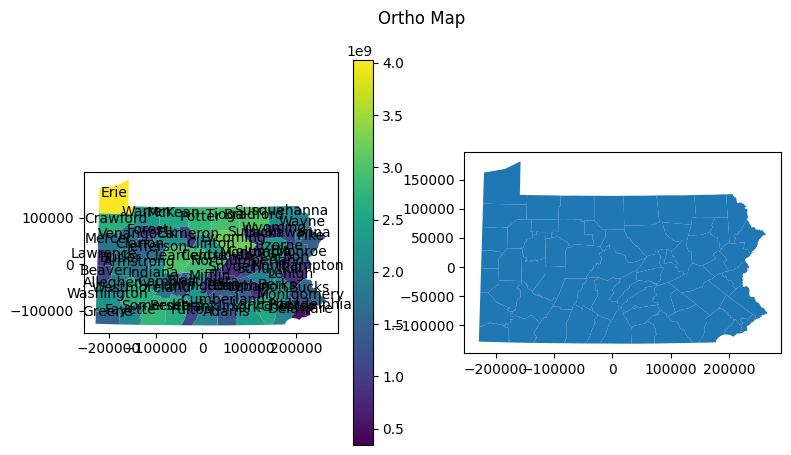

In [3]:
# select geometry for PA from GeoDF PA FIPS = 42
pa_geom = tl_us_county_gpd[tl_us_county_gpd["STATEFP"] == "42"]

# set up orthographic projection
add_area_and_label_coords(pa_geom)
centroid_x, centroid_y = calc_overall_centroid(pa_geom)
lat = centroid_y
lon = centroid_x
ortho = CRS.from_proj4(
    f"+proj=ortho +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")

# set CRS for ortho geo df
ortho_gdf = pa_geom.to_crs(ortho)

add_area_and_label_coords(ortho_gdf)
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
plot_with_labels(ortho_gdf, field_col='area', name_col='NAME', ax=axes[0])
plot_with_labels(ortho_gdf, ax=axes[1])
fig.suptitle('Ortho Map')

## Step 05

Estimate some county-wide snowfall numbers


In [4]:
# merge snowfall and cities/counties dfs
snowstorm_counties_df = pd.merge(
    left=snowstorm_df,
    right=pa_cities_counties_df,
    left_on="Location",
    right_on="Name",
    how="left",
)

# Use Geolocator to look up counties
# Geolocator times out with too many requests. If available, load the pickle
# file and skip the request
if os.path.exists(PATH_TO_PICKLE_COUNTIES_FILE):
    snowstorm_counties_df = pd.read_pickle(PATH_TO_PICKLE_COUNTIES_FILE)
else:
    # init empty list to hold locations
    locations = []

    # use Nomanatim to get missing county values
    geolocator = Nominatim(user_agent="edcmsdas")

    # iterate over rows to see which are missing (they are the np.nan floats)
    for index, row in snowstorm_counties_df.iterrows():
        # missing Counties as nan floats here
        if type(row["County"]) is float:
            # geolocate
            gl = geolocator.geocode(f"{row["Location"]} Pennsylvania US")

            # convert the location to string and save. will split to retrieve the county after
            gl_str = str(gl)

            # fill in county for the missing row
            snowstorm_counties_df.at[index, "County"] = gl_str

    # Save the dataframe as a pickle file
    snowstorm_counties_df.to_pickle(PATH_TO_PICKLE_COUNTIES_FILE)

In [5]:
# fix the missing indecies split string
snowstorm_locations_split = snowstorm_counties_df["County"].apply(
    lambda x: x.split(","))

# Get the counties from the string split
counties = []
for row in snowstorm_locations_split:
    # either already have county or missing
    if len(row) < 2:
        counties.append(row[0])
    else:
        for l in row:
            if "County" in l:
                counties.append(l.removesuffix("County").strip())

snowstorm_counties_df["County"] = counties

In [6]:
# Prune df to only columns needed
cols_to_keep = ["County", "Expected Snowfall"]
snowstorm_counties_pruned_df = snowstorm_counties_df.loc[:, cols_to_keep]

# get the mean snowfall for each county
snowstorm_county_means = snowstorm_counties_pruned_df.groupby(["County"])[
    "Expected Snowfall"].mean().to_frame().reset_index(drop=False).rename(
        columns={"Expected Snowfall": "mean_expected_snowfall"})

## Step 06

Merge snowfall data into GeoDF


In [7]:
# Merge snowfall df into GeoDataframe
gdf_snowstorm = pd.merge(
    left=snowstorm_county_means,
    right=ortho_gdf,
    left_on="County",
    right_on="NAME",
    how="right",
)

# make back into geodf
gdf_snowstorm = gpd.GeoDataFrame(gdf_snowstorm, geometry='geometry')

## Step 07

Plot snowfall map


<Axes: >

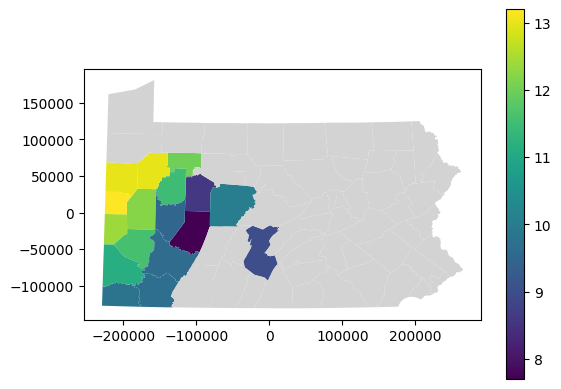

In [8]:
gdf_snowstorm.plot(
    column="mean_expected_snowfall",
    legend=True,
    missing_kwds={'color': 'lightgrey'}
)

## Step 08

Travel distances


In [9]:
# consider travel loop
travel_towns = ['Pittsburgh',
                'Scranton',
                'Allentown',
                'Philadelphia',
                'Harrisburg',
                'Pittsburgh']


# Ortho CRS
pa_muni_ortho_gpd = pa_muni_gpd.to_crs(ortho)

# PC CRS
pa_muni_pc_gpd = pa_muni_gpd.to_crs("EPSG:4326")

# add area and label coordinates to both
map(add_area_and_label_coords, (pa_muni_ortho_gpd, pa_muni_pc_gpd))

## Step 09

Travel map


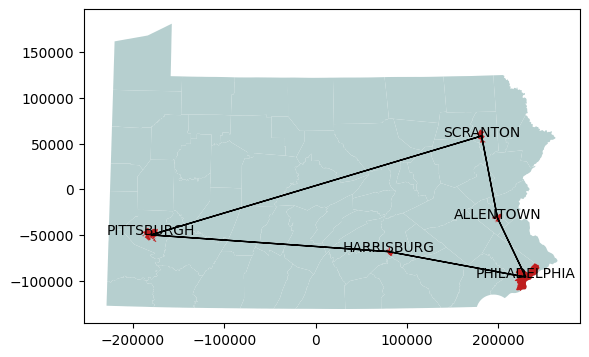

In [10]:
# make travel town upper case to match MUNICIPAL1
travel_towns_upper = [town.upper() for town in travel_towns]

# subset travel cities
pa_muni_ortho_gpd_travel_towns = pa_muni_ortho_gpd.loc[
    pa_muni_ortho_gpd["MUNICIPAL1"].isin(travel_towns_upper), :
]

# add area and label coordinates
add_area_and_label_coords(pa_muni_ortho_gpd_travel_towns)

# Create plot
fig, axes = plt.subplots(1, 1)
plot_with_labels(ortho_gdf, ax=axes, color="#b6cfcf")
plot_with_labels(pa_muni_ortho_gpd_travel_towns,
                 name_col='MUNICIPAL1', ax=axes, color="#bf1e1e")


# plot arrows
pa_muni_ortho_gpd_travel_towns["rep_point"] = pa_muni_ortho_gpd_travel_towns["geometry"].representative_point()
pa_muni_ortho_gpd_travel_towns = pa_muni_ortho_gpd_travel_towns.reset_index(
    drop=True)

for i in range(len(travel_towns_upper) - 1):

    start_point = pa_muni_ortho_gpd_travel_towns.loc[
        pa_muni_ortho_gpd_travel_towns["MUNICIPAL1"] == travel_towns_upper[i], "rep_point"
    ].iloc[0]

    end_point = pa_muni_ortho_gpd_travel_towns.loc[
        pa_muni_ortho_gpd_travel_towns["MUNICIPAL1"] == travel_towns_upper[i + 1], "rep_point"
    ].iloc[0]

    axes.arrow(
        start_point.x, start_point.y,
        end_point.x - start_point.x,
        end_point.y - start_point.y
    )

In [11]:
# travel distances
distances = []
for i in range(len(travel_towns_upper) - 1):

    start_point = pa_muni_ortho_gpd_travel_towns.loc[
        pa_muni_ortho_gpd_travel_towns["MUNICIPAL1"] == travel_towns_upper[i], "rep_point"
    ].iloc[0]

    end_point = pa_muni_ortho_gpd_travel_towns.loc[
        pa_muni_ortho_gpd_travel_towns["MUNICIPAL1"] == travel_towns_upper[i + 1], "rep_point"
    ].iloc[0]

    distances.append(start_point.distance(end_point))

np.sum(distances) / 1000
print(
    f"Orthogonal projection straight distance {(np.sum(distances) / 1000):.4f} KM")

Orthogonal projection straight distance 954.9658 KM


In [ ]:

pa_muni_pc_gpd_travel_towns = pa_muni_pc_gpd.loc[
    pa_muni_pc_gpd["MUNICIPAL1"].isin(travel_towns_upper), :
]

add_area_and_label_coords(pa_muni_pc_gpd_travel_towns)

calc_overall_centroid(pa_muni_pc_gpd_travel_towns)

distances = []
for i in range(len(travel_towns_upper) - 1):

    start_point_x, start_point_y = calc_overall_centroid(pa_muni_pc_gpd_travel_towns.loc[
        pa_muni_pc_gpd_travel_towns["MUNICIPAL1"] == travel_towns_upper[i]
    ])

    end_point_x, end_point_y = calc_overall_centroid(pa_muni_pc_gpd_travel_towns.loc[
        pa_muni_pc_gpd_travel_towns["MUNICIPAL1"] == travel_towns_upper[i + 1]
    ])

    distances.append(haversine_np(
        start_point_x, start_point_y, end_point_x, end_point_y))

print(f"Haversine distance: {np.sum(distances):.4f} KM")

Haversine distance: 955.3849 KM


The distances are almost similar, but differ due to the projections and formulas used to measure. If the towns were further away from the equator, we would likely see more of a difference.
